In [ ]:
## A Notebook to read the light curve from TASTE data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook
from astropy.time import Time
#https://docs.astropy.org/en/stable/time/

In [ ]:
# TASTE info
# Asiago - Cima Ekar
# 45° 50' 50'' N -> 45.8472
# 11° 34' 08'' E -> 11.569

# Conversion from JD-UTC to TDB
# tm.tdb[:5]
# BUT: the results would be in Earth barycentric system. 
# In order to move from the Earth BC to the Solar System BC 
# we have to correct for the "light travel time", i.e.,
# the time required by the light to travel between Earth 
# and the Solar System barycenter 

In [2]:
# read the output of apertur extraction 
sentinel_data = np.genfromtxt('Data_Files/sentinel.dat')

# 0: nf 
# 1: name
# 2: min
# 3: expt
# 4: x
# 5: y 
# 6: dx
# 7: dy
# 8: xr
# 9: yr
# 10: fw
# 11: peak
# 12: a1
# 13: a2
# 14: r1
# 15: r2
# 16: lc1
# 17: lc2
# 18: sky
# 19: abflux

In [3]:
%matplotlib widget 
%matplotlib inline

# T0: from the header of the first scientific frame 
# JD = 2455892.432384 / JD at start
jd = (sentinel_data[:,2]/1440.) + 2455892.432384 + sentinel_data[:,3]/86400./2. 
tm = Time(jd, format='jd', scale='utc', location=('45.8472d', '11.569d')) 

from astropy import coordinates as coord, units as u
target = coord.SkyCoord("07:48:06.42", "+50:13:30.53", unit=(u.hourangle, u.deg), frame='icrs')
ltt_bary = tm.light_travel_time(target)  

# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10)
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
ltt_plot = tm_plot.light_travel_time(target)  

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()

target.transform_to(frame='barycentricmeanecliptic')

<SkyCoord (BarycentricMeanEcliptic: equinox=J2000.000): (lon, lat) in deg
    (109.33366373, 28.58413499)>

In [4]:
# BJD_TDB is given by the sum of the time at the Earth barycenter + the ligh travel time
# But note that "tm" and "ltt_bary" are NOT arrays but objects. 
# type(tm) -> astropy.time.core.Time
# type(ltt_bary) -> astropy.time.core.DeltaTime


# They are two different kinds of objects as well! According to the documentation, 
# the first one is converted to an array by using 
# tm.tdb.to_value('jd')

bjd_tdb = tm.tdb.to_value('jd') + ltt_bary.to_value(u.d)



In [5]:
# A test
print(jd[:4])
print(bjd_tdb[:4])
print((2455892.43670666-2455892.436706672)*86400)

[2455892.43241294 2455892.43248932 2455892.43256571 2455892.43263516]
[2455892.43670666 2455892.43678305 2455892.43685944 2455892.43692889]
-0.0010460615158081055


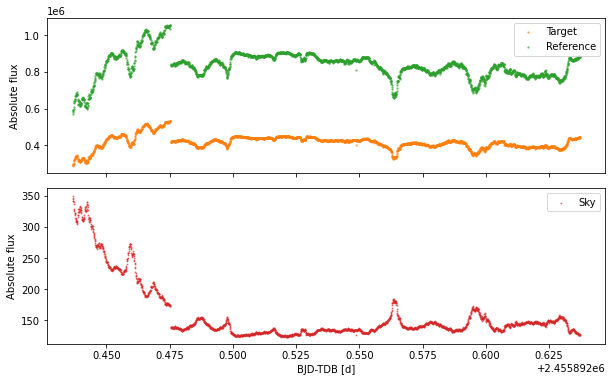

In [6]:
# Plot: "raw" light curve of target and reference
%matplotlib widget 
%matplotlib inline
# 13: a2
# 15: r2
# 18: sky

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,6))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data[:,13], c='C1', s=2, alpha=0.5, label='Target')
ax1.scatter(bjd_tdb, sentinel_data[:,15], c='C2', s=2, alpha=0.5, label='Reference')
ax2.scatter(bjd_tdb, sentinel_data[:,18], c='C3', s=1, alpha=0.5, label='Sky')

# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Absolute flux')
ax2.set_ylabel('Absolute flux')

ax1.legend()
ax2.legend()
plt.show()


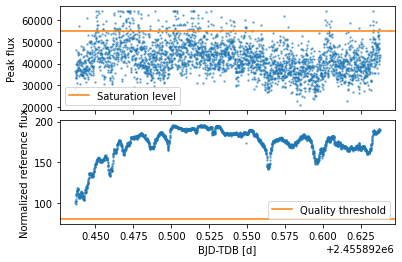

167


In [7]:
# Plot 1: Check if either the peak value of BOTH aperture is below the saturation level, 
# Plot 1: check if the reference star has a stable flux:
%matplotlib widget 
%matplotlib inline
# 11: peak
# 19: abflux

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data[:,11], c='C0', s=2, alpha=0.5)
ax1.axhline(55000, c='C1', label='Saturation level')

ax2.scatter(bjd_tdb, sentinel_data[:,19], c='C0', s=2, alpha=0.5)
ax2.axhline(80, c='C1', label='Quality threshold')
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Peak flux')
ax2.set_ylabel('Normalized reference flux')

ax1.legend()
ax2.legend()
plt.show()

quality_selection = (sentinel_data[:,11] < 55000) & (sentinel_data[:,19] > 80)
print(len(sentinel_data[:,19]) - len(sentinel_data[quality_selection,19]))

AttributeError: 'AxesSubplot' object has no attribute 'set_ylimit'

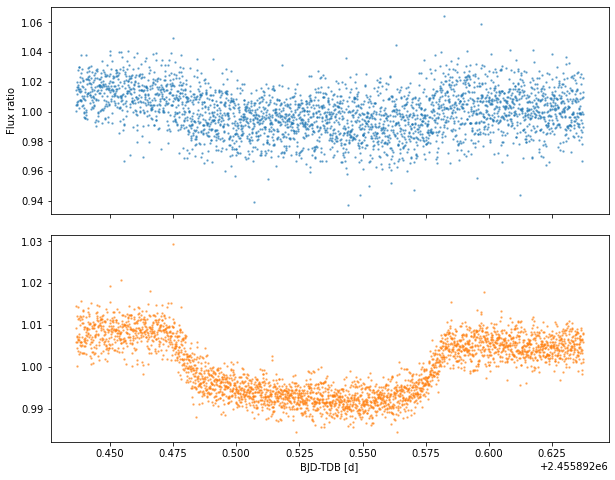

In [9]:
# Plot: ratio of target flux divided by the reference flux 
%matplotlib widget 
%matplotlib inline
# Aperture #1
# 12: a1
# 14: r1
# 16: lc1 = a1/r1

# Aperture #2
# 13: a2
# 15: r2
# 17: lc2 = a2/r2

# For a better comparison, we devided by the median 
median_aperture1 = np.median(sentinel_data[:,16])
median_aperture2 = np.median(sentinel_data[:,17])

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,8))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data[:,16] / median_aperture1, c='C0', s=2, alpha=0.5, label='Aperture #1')
ax2.scatter(bjd_tdb, sentinel_data[:,17] / median_aperture2, c='C1', s=2, alpha=0.5, label='Aperture #2')
ax2.set_xlabel('BJD-TDB [d]')
ax1.set_ylabel('Flux ratio')
ax1.set_ylim(0.99,1)
ax2.set_ylabel('Flux ratio')

ax1.legend()
ax2.legend()
plt.show()
mean = median_aperture2 = np.median(sentinel_data[quality_selection,17])
print(mean)

In [9]:
# Error computation
lc1_err = sentinel_data[:,16] * np.sqrt(  1./ sentinel_data[:,12] +   1./ sentinel_data[:,14]   )
lc2_err = sentinel_data[:,17] * np.sqrt(  1./ sentinel_data[:,13] +   1./ sentinel_data[:,15]   )



In [10]:
# Saving to a file using the PyORBIT standard
# lightcurve normalization will be included in the model

fileout = open('Data_Files/XO_TASTE_aperture1.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection]-2450000.0, sentinel_data[quality_selection,16], lc1_err[quality_selection]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()

fileout = open('Data_Files/XO_TASTE_aperture2.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection]-2450000.0, sentinel_data[quality_selection,17]/mean, lc2_err[quality_selection]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()